In [1]:
! pip install quandl 
!pip install yfinance

     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 2.3MB 14.2MB/s 
  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6076 sha256=06b945bde63b629318d0ab17087b9d0d83406d3aada337e487d0fdbbc8fdbed8
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: more-itertools 7.2.0
    Uninstalling more-itertools-7.2.0:
      Successfully uninstalled more-itertools-7.2.0
  Created wheel for yfinance: filename=yfinance-0.1.50-py2.py3-none-any.whl size=21556 sha256=d87d7215d2e9eede8bedd690462302a7a5ab0467f123fee30feaaf754fb57ec8
  Stored in directory: /root/.cache/pip/wheels/19/2a/e6/b4d4cc977576e18220a36866acf2f2cf7241f16af5f8795b17
Successfully built yfin

In [13]:
import yfinance as yf  
import time
import quandl 
import datetime as dt
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pylab as plt
import glob, os
from fastai.vision import *
from fastai.metrics import accuracy
import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from sklearn.metrics import roc_curve, auc
import torch
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
def plot_candles(pricing = None, title=None,
                 volume_bars=False,
                 color_function=None,
                 overlays=None,
                 technicals=None,
                 technicals_titles=None,
                 save =False,
                 name = None,
                 multi_stocks = None,
                 Bollinger_Band = None,
                 start="2016-01-01",
                 end=dt.datetime.now()):
    """ 
    The orginal code for this code was obtained
    from https://www.quantopian.com/posts/plot-candlestick-charts-in-research 
    and was modified. 
    
    
    Plots a candlestick chart using quantopian pricing data.
    
    
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      overlays: A list of additional data series to overlay on top of pricing.  Must be the same length as pricing.
      technicals: A list of additional data series to display as subplots.
      technicals_titles: A list of titles to display for each technical indicator.
    """
    def default_color(index, open_price, close_price, low, high):
        return 'r' if open_price[index] > close_price[index] else 'g'
    color_function = color_function or default_color
    overlays = overlays or []
    technicals = technicals or []
    technicals_titles = technicals_titles or []

    
    subplot_count = 1
    if volume_bars:
        subplot_count = 2
    if technicals:
        subplot_count += len(technicals)
    
    if multi_stocks: 
        subplot_count = len(multi_stocks)*2
        
    if subplot_count == 1:
        fig, ax1 = plt.subplots(1, 1)
    

    else:
        ratios = np.insert(np.full(subplot_count - 1, 1), 0, 3)
        fig, subplots = plt.subplots(subplot_count, 1, sharex=True, gridspec_kw={'height_ratios': ratios})
        
        
    
    
    for i, ticker in enumerate(multi_stocks):
      # get the data 20 day before start to calculate rolling mean and std and then clip it 
        
        pricing = yf.download(ticker,start- datetime.timedelta(days=40),end)
        ax1 = subplots[i*2]
   
        pricing['30 Day MA'] = pricing['Adj Close'].rolling(window=20).mean()
        pricing['30 Day STD'] = pricing['Adj Close'].rolling(window=20).std()
        pricing['Upper Band'] = pricing['30 Day MA'] + (pricing['30 Day STD'] * 2)
        pricing['Lower Band'] = pricing['30 Day MA'] - (pricing['30 Day STD'] * 2)
         # clip the start -20 to start
        pricing.reset_index(inplace =True)
        pricing = pricing[pricing['Date']>=start_date]
        pricing.set_index('Date',inplace = True)      
        open_price = pricing['Open']
        close_price = pricing['Close']
        low = pricing['Low']
        high = pricing['High']
        
        oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
        oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
        x = np.arange(len(pricing))
        candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
        candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
        lines = ax1.vlines(x + 0.4, low, high, color=candle_colors, linewidth=1)
        ax1.xaxis.grid(False)
        ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
        ax1.plot(pricing['Close'].values,color = 'b')
        # Assume minute frequency if first two bars are in the same day.
        frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
        time_format = '%d-%m-%Y'
        if frequency == 'minute':
            time_format = '%H:%M'

        for overlay in overlays:
            ax1.plot(x, overlay)
        # Plot volume bars if needed
        if volume_bars:
            ax2 = subplots[i*2+1]
            volume = pricing['Volume']
            volume_scale = None
            scaled_volume = volume
            if volume.max() > 1000000:
                volume_scale = 'M'
                scaled_volume = volume / 1000000
            elif volume.max() > 1000:
                volume_scale = 'K'
                scaled_volume = volume / 1000
            ax2.bar(x, scaled_volume, color=candle_colors)
            ax2.xaxis.grid(False)
        
        x_axis = pricing.reset_index().reset_index()['index'] 

        ax1.fill_between(x_axis, pricing['Upper Band'], pricing['Lower Band'], color='grey')

        # Plot additional technical indicators
        for (i, technical) in enumerate(technicals):
            ax = subplots[i - len(technicals)] # Technical indicator plots are shown last
            ax.plot(x, technical)
            if i < len(technicals_titles):
                ax.set_title(technicals_titles[i])
                
                
    if save: plt.savefig('/content/drive/My Drive/Stocks/'+name) 

Load Google Drive

In [5]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Plot AMZN and MSFT

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


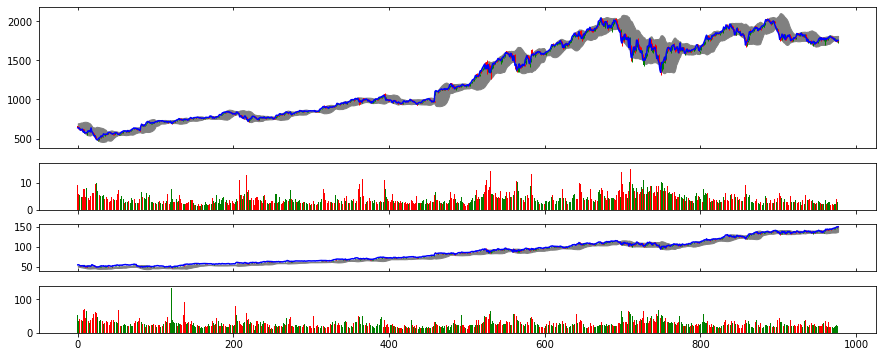

In [6]:
windows = 30 
start_date = "2016-01-01"
start_date = pd.to_datetime(start_date)
end_date = dt.datetime.now()
plot_candles(  volume_bars=True, save = True,name = 'amazon.png', multi_stocks=['AMZN','MSFT'],Bollinger_Band = True, start = start_date, end = end_date )


In [0]:
# Uncomment this block if you want to delete and create a new folder
# ! rm -r "/content/drive/My Drive/Stocks/"
# ! /bin/mkdir -p "/content/drive/My Drive/Stocks"

# Training the model

Parameters

In [0]:

# stickers = ['AMZN','MSFT','WMT','NFLX']
stickers = ['AMZN']
windows = 30 
start_date = "2012-01-01"

In [9]:
start_date = pd.to_datetime(start_date)
Final_date = dt.datetime.now() 
#  some days stock market is closed so I only get data for the day that 
#  we have data for
data = yf.download('AMZN',start_date,Final_date)
# Label 
data['profit']= (data.Close.shift(-1) - data.Close)/data.Close.shift(-1)
data.dropna(how = 'any',inplace= True)
data['profit']= data['profit'] >= 0.02
data['profit']= data['profit'].astype('int32')

label= data.reset_index ()
label= label[['profit','Date']]
# Clean the data

train_dir = 'content/drive/My Drive/Stocks/'

label = label.shift(-(windows-1))
label.dropna(how = 'any',inplace= True)
label['profit']= label['profit'].astype('int32')
label.drop(label.index[-1], inplace = True)
label['path'] = label['Date'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
label['Date_str']=label['Date'].astype('str')



[*********************100%***********************]  1 of 1 completed


## Generate Pictures from charts 
Get the date from dataframe 

In [10]:
start_date = label.iloc[0].Date
os.chdir("/content/drive/My Drive/Stocks")
list_file = []
for file in glob.glob("*.png"):
    list_file.append(file)

   
for ii in tqdm(range(label.shape[0])):
    plt.clf()
    end_date   = label.iloc[ii].Date 
    start_date = pd.to_datetime(label.iloc[ii].Date) - datetime.timedelta(days=windows)
    if label.iloc[ii].Date_str+'.png' not in list_file:
       print("file name:   " ,label.iloc[ii].Date_str)
       plot_candles(  volume_bars=True, save = True, Bollinger_Band = True, name =label.iloc[ii].Date_str, multi_stocks= stickers , start = start_date, end = end_date )
    ii += 1

label['Date'] = label['Date'].astype('str')
label['path'] = label['Date'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))

os.chdir("../../../..")

100%|██████████| 1953/1953 [00:01<00:00, 1614.69it/s]


<Figure size 1080x432 with 0 Axes>

In [0]:
# Data Augmentation and Transformation up to Data Bunch
tfms = get_transforms()
sz= 600 # 600 ,20 good 
bs =10

src = (ImageList.from_df(df=label,path ="..",cols='path') 
        .split_by_idx(valid_idx=range(int(label.shape[0] - label.shape[0]*0.3),label.shape[0]))
        .label_from_df(cols='profit') 
      )
data= (src.databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)      
       )

In [28]:
manualSeed = 100
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)
learn = cnn_learner(data, models.resnet50)
# Let's fit a couple of cycles
learn.fit_one_cycle(2)


epoch,train_loss,valid_loss,time
0,0.755021,0.507046,00:59
1,0.373679,0.331444,00:59


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.74E-06


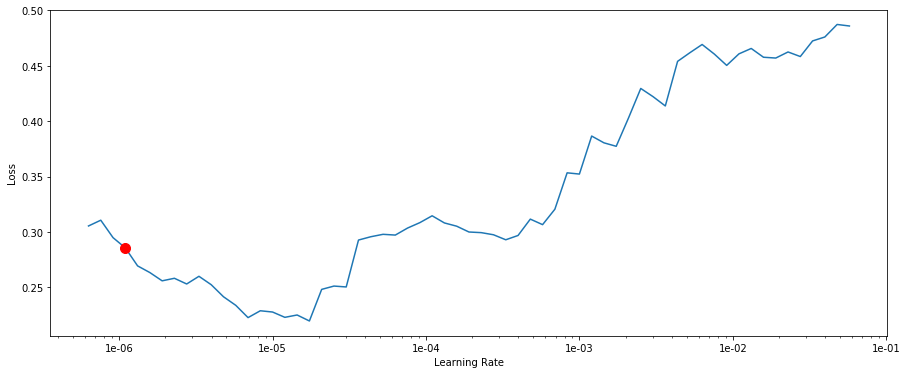

In [15]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)


In [0]:
# Let's fit some more with a more accurate learning rate
learn.fit_one_cycle(8, max_lr=slice(1.10E-06))
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,time
0,0.234420,0.338849,00:59


In [0]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [20]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 216, 540]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 216, 540]       128        True      
______________________________________________________________________
ReLU                 [64, 216, 540]       0          False     
______________________________________________________________________
MaxPool2d            [64, 108, 270]       0          False     
______________________________________________________________________
Conv2d               [64, 108, 270]       4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 108, 270]       128        True      
______________________________________________________________________
Conv2d               [64, 108, 270]       36,864     True      
___________________________________________________